A new version of Albumentations is available: '2.0.8' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


Notebook Color Scheme: 


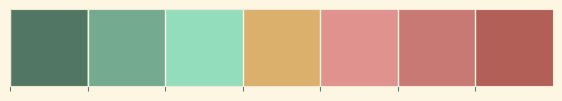

In [1]:
# 1. Handle datasets
import io
import os
import gc
import sys
import cv2
import time
import timm
import copy
import math
import cvzone
import random
import pydicom
import dicomsdl
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import tifffile as tiff
import imageio.v3 as iio
import SimpleITK as sitk
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
from collections import Counter
from joblib import Parallel, delayed
from pydicom.pixel_data_handlers.util import apply_voi_lut

# 2. Visualize datasets
import datetime as dtime
from datetime import datetime
import itertools
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px
import plotly.figure_factory as pff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Rectangle
from IPython.display import display_html, clear_output, display, Image

# 3. Preprocess datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
## import iterative impute
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
## fastai
# from fastai.data.all import *
# from fastai.vision.all import *

# 4. machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
## for classification
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import KBinsDiscretizer
from xgboost import XGBClassifier

# 5. Deep Learning
## Augmentation
import ultralytics
from ultralytics import YOLO
from roboflow import Roboflow
from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import ViTModel, ViTFeatureExtractor, ViTForImageClassification

## Torch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor, LongTensor
from torchvision.utils import draw_bounding_boxes
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, SequentialLR, LinearLR
from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50, ResNet50_Weights, detection
from torchvision import datasets, transforms

# 6. metrics
import optuna
from scipy.stats import mode
from timeit import default_timer as timer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.metrics import f1_score, r2_score
from sklearn.metrics import classification_report

# 7. ignore warnings   
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 8. For displaying and wandb
import wandb
# wandb.login()
plt.style.use("Solarize_Light2")
plt.rcParams.update({'font.size': 16})

# 0. Customization
parent_dir = r"D:\Aquarium Combined.v2-raw-1024.coco"
# WANDB_PROJ_NAME = "RSNA_Breast_Cancer_Detection"
# CONFIG = {
#     'competition': 'RSNA_Breast_Cancer',
#     '_wandb_kernel': 'aot'
# }

torch.backends.cudnn.benchmark = True
my_colors = ['#517664', '#73AA90', '#94DDBC', '#DAB06C',
             '#DF928E', '#C97973', '#B25F57']
CMAP1 = ListedColormap(my_colors)
print("Notebook Color Scheme: ")
sns.palplot(sns.color_palette(my_colors))
plt.show()

In [2]:
def show_sample(classes, sample):
    
    # The sample image is currently in range [0, 1]. To paint the bboxes in the sample
    # we need to convert the sample back to [0, 255]
    image_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
    
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(
        draw_bounding_boxes(
            image_int, sample[1]['boxes'],
            [ classes[i] for i in sample[1]['labels']],
            width=4
        ).permute(1, 2, 0)
    )
    

In [3]:
def show_sample_2(classes, sample):
    # The sample image is currently in range [0, 1]. To paint the bboxes in the sample
    # we need to convert the sample back to [0, 255]
    image_int = torch.tensor(sample[0] * 255, dtype=torch.uint8).numpy() 
    boxes = sample[1]['boxes']
    
    # Ensure that coordinates are integers
    # Reorder to height, width, channels for visualization
    image_int = np.moveaxis(image_int, 0, -1)  
    
    fig, axis = plt.subplots(1, 1, figsize=(10, 5))
    
    for box in boxes:
        x1, y1, x2, y2 = box.int().tolist()
        cv2.rectangle(
            image_int,
            (x1, y1),
            (x2, y2),
            (220, 0, 0), 3
        )
    
    axis.set_axis_off()
    axis.imshow(image_int)

## Dataset

#### 1. Global params

In [4]:
from utils import CreateLoader, transforms, set_seed

set_seed()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

coco = COCO(os.path.join(parent_dir, 'train', '_annotations.coco.json'))
categories = coco.cats
n_classes = len(categories.keys())

classes = [ cat[1]['name'] for cat in categories.items() ]
print(f'Classes: {classes} - Length = {n_classes}')

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Classes: ['creatures', 'fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray'] - Length = 8


#### 3. Dataset

In [5]:
class COCODetection(datasets.VisionDataset):
    
    def __init__(self, root = None, split = 'train',
                 transforms = None, transform = None, target_transform = None):
        super().__init__(root, transforms, transform, target_transform)
        
        self.split = split
        self.coco = COCO(os.path.join(root, split, '_annotations.coco.json'))
        
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        
        return cv2.cvtColor(
            cv2.imread(os.path.join(self.root, self.split, path)),
            cv2.COLOR_BGR2RGB
        )
    
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        
        id = self.ids[index]
        image = self._load_image(id)
        
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        # notion format for Albumentations
        boxes = [ t['bbox'] + [t['category_id']] for t in target ]   
        
        if self.transforms is not None:
            transformed = self.transforms(image = image, bboxes = boxes)
            
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = []
        for box in boxes:
            x, y, w, h = box[0], box[1], box[2], box[3]
            new_boxes.append([x, y, x + w, y + h, box[4]])
            
        boxes_tensor = torch.tensor([b[:4] for b in new_boxes], dtype=torch.float32)
        labels_tensor = torch.tensor([b[4] for b in new_boxes], dtype=torch.int64)
        
        # Newly created target for model to use
        target_dict = {}
        target_dict['boxes'] = boxes_tensor
        target_dict['labels'] = labels_tensor
        target_dict['image_id'] = torch.tensor([ t['image_id'] for t in target ])
        target_dict['area'] = (boxes_tensor[:, 3] - boxes_tensor[:, 1]) * (boxes_tensor[:, 2] - boxes_tensor[:, 0])
        target_dict['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        
        return image.div(255), target_dict
    
    def __len__(self): return len(self.ids)
        

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


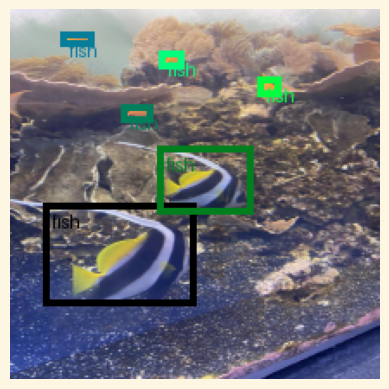

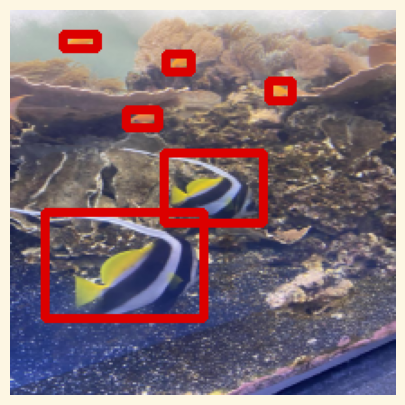

In [6]:
# === Sanity Check ===
train_dataset = COCODetection(root=parent_dir, transforms=transforms(214, True))

sample = train_dataset[3]
show_sample(classes, sample)
show_sample_2(classes, sample)

## Model

In [7]:
from utils import cus_fasterrcnn_resnet50_fpn, cus_fasterrcnn_effnet, cus_fasterrcnn_swin

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Sanity Check:   0%|          | 0/447 [00:00<?, ?it/s]

Sanity Check - Prediction:   0%|          | 0/447 [00:00<?, ?it/s]

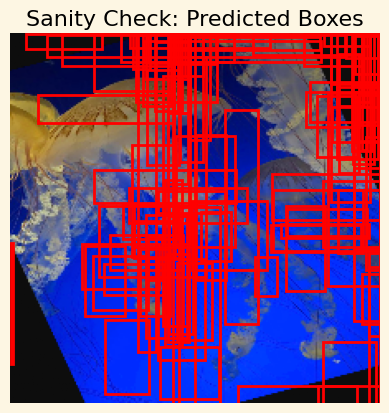

In [8]:
train_dataset = COCODetection(root=parent_dir, transforms=transforms(224, True))
train_loader = CreateLoader(train_dataset, batch_size=1, shuffle=False)

model = cus_fasterrcnn_swin(num_classes=n_classes, size=224).to(DEVICE)
model.transform.min_size = [448]
model.transform.max_size = 448
model.train()  # Set the model to evaluation mode

scaler = torch.amp.GradScaler(DEVICE)
optimizer = torch.optim.SGD(
    [p for p in model.parameters() if p.requires_grad], 
    lr=0.001, momentum=0.9, weight_decay=1e-4, 
    nesterov=True
)

# Sanity check loop
for images, targets in tqdm(train_loader, desc="Sanity Check"):
    images = [image.to(DEVICE) for image in images]
    targets = [{k: v.to(DEVICE) for k, v in target.items()} for target in targets]
    
    optimizer.zero_grad()

    with torch.amp.autocast('cuda'):
        out = model(images, targets)
        losses = sum(out.values())
    
    scaler.scale(losses).backward()
    scaler.step(optimizer)
    scaler.update()
    
    break

model.eval()
with torch.no_grad():
    for images, targets in tqdm(train_loader, desc="Sanity Check - Prediction"):
        images = [image.to(DEVICE) for image in images]
        preds = model(images)
        break

image = images[0].cpu().numpy().transpose(1, 2, 0)
plt.imshow(image)

for box in preds[0]['boxes']:
    x0, y0, x1, y1 = box.cpu().numpy()
    plt.gca().add_patch(plt.Rectangle(
        (x0, y0), x1 - x0, y1 - y0,
        fill=False, color='r', linewidth=2
    ))

plt.title("Sanity Check: Predicted Boxes")
plt.axis('off')
plt.show()
    
del model
gc.collect()
torch.cuda.empty_cache ()

# Training Session

In [9]:
from torchvision.ops import box_iou
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from sklearn.model_selection import KFold
from utils import data_to_device, load_ensemble_models, ensemble_wbf, compute_detection_metrics

HISTORY = []
VERSION = 2
FOLDS = 2
EPOCHS = 2
FULL_SIZE_EPOCH = 50
MIN_THRESHOLD_EPOCHS = 75
PATIENCE = 5
SCORE_WEIGHT = {'map50': 0.5, 'f1': 0.5}

SMALL_SIZE = 224
FULL_SIZE = 448

In [ ]:
train_dataset = COCODetection(
    root=parent_dir, split='train', transforms=transforms(SMALL_SIZE, True)
)
valid_dataset = COCODetection(
    root=parent_dir, split='valid', transforms=transforms(SMALL_SIZE, False)
)


def train_folds(lr, batch_size, trial, score_thr = 0.3):
    
    topModelPaths = []  # Save the paths pointing to the best models
    events        = []  # Saving metrics for later visualization
        
    def saveBestModel(avg_loss, map_50, f1, score, foldNum, epochNum):
        model_name = f"VER{VERSION}_TRIAL{trial}_Fold{foldNum}_Epoch{epochNum+1}_AverageLoss{avg_loss:.3f}_MAP50{map_50:.3f}_F1{f1:.3f}_SCORE{score:.3f}.pth"
        torch.save(current_model.state_dict(), model_name)
            
        topModelPaths.append((model_name, score))
        topModelPaths.sort(key=lambda x: x[1], reverse=True)
            
        if len(topModelPaths) > 3:
            removedModel = topModelPaths.pop()
            os.remove(removedModel[0])
            print(f"Deleted worst model: {removedModel[0]}")
    
    
    def filter_invalid_bboxes(targets):
        valid_targets = []
        for target in targets:
            boxes = target['boxes']
            
            valid_bboxes = boxes[
                (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])
            ]
            
            target['boxes'] = valid_bboxes
            valid_targets.append(target)
        
        return valid_targets
    
    
    def train_function():
    
        # print(f'\n ------------ Epoch {epoch + 1} ------------ ')
        current_model.train()
        current_model.to(DEVICE)
        progBar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False)
        
        running_loss = 0.0
        for data in progBar:
            
            # 1. zero grads BEFORE the forward
            optimizer.zero_grad()
            images, targets = data_to_device(data, DEVICE)
            
            # WARNING: Some augmentations lead to some bboxes being 0. We need to filter those out
            targets = filter_invalid_bboxes(targets)
            
            # 2. forward + backward under autocast
            with torch.amp.autocast('cuda'):
                outputs = current_model(images, targets)
                losses = sum(loss for loss in outputs.values())
               
            scaler.scale(losses).backward()     # scale & backward
            scaler.step(optimizer)              # unscale
            scaler.update()                     # update the scale for next iteration
            
            # 3. batch-level scheduler
            scheduler.step()
            running_loss += losses.item()
        
        avg_loss = running_loss / len(train_loader)
        return avg_loss

    @torch.no_grad()
    def evaluate_function(avg_loss):
        
        def compute_f1(pred_boxes, pred_labels, gt_boxes, gt_labels):
            
            iou     = box_iou(pred_boxes, gt_boxes)
            matches = torch.nonzero(iou > 0.5, as_tuple = False)
            scores  = iou[matches[:, 0], matches[:, 1]]
            indices = torch.argsort(scores, descending = True)
            
            tp = 0
            matched_pred, matched_gt = set(), set()
            
            for idx in indices:
                
                p, g = matches[idx, 0].item(), matches[idx, 1].item()
                if p not in matched_pred and g not in matched_gt and pred_labels[p] == gt_labels[g]:
                    tp += 1
                    matched_pred.add(p)
                    matched_gt.add(g)
            
            fp = pred_boxes.size(0) - tp
            fn = gt_boxes.size(0) - tp
            return tp, fp, fn
        
        
        current_model.eval()
        metric = MeanAveragePrecision(iou_type='bbox')
        total_tp = total_fp = total_fn = 0
        nonlocal best_overall_score, patience_f
        
        progBar = tqdm(valid_loader, desc=f"Epoch {epoch+1} [Valid]", leave=False)
        with torch.no_grad():
            for data in progBar:
                
                images, targets = data_to_device(data, DEVICE)
                targets = filter_invalid_bboxes(targets)
                outputs = current_model(images)
                
                # Filter out all garbage bboxes 
                filtered = []
                for out in outputs:
                    keep = out['scores'] >= score_thr
                    filtered.append({
                        'boxes':  out['boxes'][keep],
                        'labels': out['labels'][keep],
                        'scores': out['scores'][keep]
                    })
                outputs = filtered
                
                # skip this batch if you got literally nothing on both sides
                all_pred_boxes = torch.cat([o['boxes'] for o in outputs])
                all_gt_boxes   = torch.cat([t['boxes'] for t in targets])
                if all_pred_boxes.numel() == 0 and all_gt_boxes.numel() == 0:
                    continue
                
                metric.update(outputs, targets)
                
                for out, tgt in zip(outputs, targets):
                    pb, pl = out['boxes'].cpu(), out['labels'].cpu()
                    gb, gl = tgt['boxes'].cpu(), tgt['labels'].cpu()
                    tp, fp, fn = compute_f1(pb, pl, gb, gl)
                    
                    total_tp += tp
                    total_fp += fp
                    total_fn += fn
                    
        results = metric.compute()
        map     = results['map'].item()
        map_50  = results['map_50'].item()
        map_75  = results['map_75'].item()
        
        precision = total_tp / (total_tp + total_fp) if total_tp+total_fp > 0 else 0
        recall    = total_tp / (total_tp + total_fn) if total_tp+total_fn > 0 else 0
        f1        = 2*precision*recall / (precision+recall) if precision+recall > 0 else 0
        
        duration = str(time.time() - start_time)[:7]
        log = f'{duration} | Epoch: {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | MAP: {map:.3f} | MAP_50: {map_50:.3f} | F1: {f1:.3f}'
        # print(log)
        add_in_file(log, f, trial=trial)
        
        current_score = SCORE_WEIGHT['map50'] * map_50 + SCORE_WEIGHT['f1'] * f1
        events.append({
            'fold'       : fold + 1,
            'lr'         : lr,
            'batch_size' : batch_size,
            'score_thr'  : score_thr,
            
            'epoch' : epoch,
            'loss'  : avg_loss,
            'map'   : map,
            'map_50': map_50,
            'map_75': map_75,
            
            'precision': precision,
            'recall'   : recall,
            'f1'       : f1,
            'score'    : current_score
        })
        
        
        if best_overall_score is None or current_score > best_overall_score:
            best_overall_score = current_score
            
            saveBestModel(
                avg_loss, 
                f1, 
                map_50, 
                score = best_overall_score,
                foldNum = fold + 1,
                epochNum = epoch,
            )
            print(f"Saved new best model at Epoch {epoch+1}\n")
            
            return best_overall_score, PATIENCE
        else:
            return best_overall_score, patience_f - 1
    
    def add_in_file(text, f, trial):
        with open(f"logs_{VERSION}_trial_{trial}.txt", "a+") as f:
            f.write(text)
    
    with open(f"logs_{VERSION}.txt", "w+") as f:
        print(f"Training with learning rate: {lr} and batch size: {batch_size}\n")
        f.write(f"Training with learning rate: {lr} and batch size: {batch_size}\n")
    
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset.ids)):
        
        print(f" ------------ Fold: {fold+1} ------------")
        add_in_file(f" ------------ Fold: {fold+1} ------------\n", f, trial=trial)
        
        torch.cuda.empty_cache()
        best_overall_score = None
        patience_f = PATIENCE
        current_model = cus_fasterrcnn_swin(n_classes, size=SMALL_SIZE).to(DEVICE)
        # current_model = torch.compile(current_model)
        
        
        # ─── ANCHOR‐BOX OPTIMIZATION VIA K-MEANS ──────────────────────────────────────
        all_wh = []
        
        for ann in train_dataset.coco.loadAnns(train_dataset.coco.getAnnIds()):
            w, h = ann['bbox'][2], ann['bbox'][3]
            all_wh.append([w ,h])
        
        clusters = KMeans(n_clusters=9, random_state=42).fit(np.array(all_wh)).cluster_centers_
        anchors = sorted(
            [tuple(map(int, xy)) for xy in clusters],
            key= lambda x: x[0] * x[1]
        )
        
        current_model.rpn.anchor_generator.sizes = tuple(
            [anchors] * len(current_model.rpn.anchor_generator.sizes)
        )
        #  ─────────────────────────────────────────────────────────────────────────────
        
        
        # ─── CLASSES IMBALANCE ──────────────────────────────────────────────────────────
        all_labels = []
        for ann in train_dataset.coco.loadAnns(train_dataset.coco.getAnnIds()):
            all_labels.extend(
                ann['category_id'] for ann in train_dataset.coco.loadAnns([ann['id']])
            )
        label_counts = Counter(all_labels)
        total_samples = len(all_labels)
        
        class_weights = {label: total_samples / count for label, count in label_counts.items()}
        
        # build an image-level weight list:
        image_weights = []
        for idx in train_idx:
            img_id = train_dataset.ids[idx]
            anns   = train_dataset.coco.loadAnns(train_dataset.coco.getAnnIds(img_id))
            w = sum(class_weights[a['category_id']] for a in anns) / len(anns)
            image_weights.append(w)
            
        
        sampler = WeightedRandomSampler(weights=image_weights, num_samples=len(image_weights), replacement=True)
        # ───────────────────────────────────────────────────────────────────────────────
        
        
        # ─── PREPARE DATASET ──────────────────────────────────────────────────────────
        train_subset = Subset(train_dataset, train_idx)
        val_subset   = Subset(train_dataset, val_idx)
        
        train_loader = CreateLoader(train_subset, batch_size=batch_size, shuffle=True, sampler=sampler)
        valid_loader = CreateLoader(val_subset, batch_size=batch_size, shuffle=False)
        # ───────────────────────────────────────────────────────────────────────────────
        
        
        # ─── OPTIMIZER & SCHEDULER + GRAD CLIPPING ─────────────────────────────────────────────────────
        optimizer = torch.optim.AdamW(current_model.parameters(), lr=lr, weight_decay=1e-5)
        WARMUP_STEPS = 500
        warm_up = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor = 0.1, total_iters = WARMUP_STEPS
        )
        one_cycler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=lr,
            steps_per_epoch=len(train_loader), epochs=EPOCHS
        )
        scheduler = torch.optim.lr_scheduler.SequentialLR(
            optimizer,
            schedulers = [warm_up, one_cycler],
            milestones = [WARMUP_STEPS]
        )
        # ───────────────────────────────────────────────────────────────────────────────
        
        scaler = torch.amp.GradScaler(DEVICE)
                
        for epoch in range(EPOCHS):
            
            # ─── PROGRESSIVE RESIZING ──────────────────────────────────────────────────────
            if epoch == FULL_SIZE_EPOCH:
                print("Switching to FULL_SIZE transforms")
                
                # 0. Clip gradients to prevent gradient explosion
                torch.nn.utils.clip_grad_norm_(current_model.parameters(), max_norm=5.0)
                
                # 1. bump the model’s internal resize (ONLY IF YOU ARE USING TRANSFORMER BACKBONE)
                current_model.transform.min_size = [FULL_SIZE]
                current_model.transform.max_size = FULL_SIZE
                
                # 3. increase to full size image for better learning
                train_dataset.transforms = transforms(FULL_SIZE, True)
                valid_dataset.transforms = transforms(FULL_SIZE, False)
                
                # 4. re-create subsets and loaders
                train_subset = Subset(train_dataset, train_idx)
                val_subset = Subset(train_dataset, val_idx)
                
                train_loader = CreateLoader(train_subset, batch_size=batch_size, shuffle=True, sampler=sampler)
                valid_loader = CreateLoader(val_subset, batch_size=batch_size, shuffle=False)
            # ───────────────────────────────────────────────────────────────────────────────
                   
            
            start_time = time.time()
            avg_loss = train_function()
            best_overall_score, patience_f = evaluate_function(avg_loss)
            
            # ───────── EARLY STOPPING ────────────────────────────────────────────────────────────────
            if epoch > MIN_THRESHOLD_EPOCHS and patience_f == 0:
                msg = f"Early stopping | Best f1 and mAP score: {best_overall_score:.4f}\n"
                print(msg)
                add_in_file(msg, f, trial=trial)
                break
            elif epoch <= MIN_THRESHOLD_EPOCHS: patience_f = PATIENCE
            # ──────────────────────────────────────────────────────────────────────────────────────────
            
            # print(f"Epoch {epoch+1}: patience_f = {patience_f}")
        
        del train_loader, valid_loader, train_subset, val_subset, current_model   
        gc.collect()
        torch.cuda.empty_cache()
        
    return topModelPaths, events

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [11]:
all_gt    = []
all_preds = []
def objective(trial):
    trial_number = trial.number
    lr         = trial.suggest_loguniform('lr', 1e-4, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [4, 8])
    score_thr  = trial.suggest_float('score_thr', 0.3, 0.5, step = 0.1)
    
    topModelPaths, events = train_folds(
        lr=lr, batch_size=batch_size, trial=trial_number, score_thr=score_thr
    ) 
    
    # Store history for later visualization
    for event in events:
        event['trial'] = trial_number
        HISTORY.append(event)
    
    # pull out only the paths
    model_paths = [path for (path, score) in topModelPaths]
    models = load_ensemble_models(
        model_paths = model_paths, 
        model_type  = cus_fasterrcnn_swin,
        num_classes = n_classes,
        size        = SMALL_SIZE,
        device      = DEVICE
    )
    
    # run ensemble on *all* validation images
    
    valid_loader = CreateLoader(valid_dataset, batch_size=1, shuffle=False)
    
    for img, targets in valid_loader:
        img_tensor = img[0]
        out = ensemble_wbf(models, img_tensor)

        # collect GT vs ensembled preds for metric
        all_gt.append(targets[0])
        all_preds.append(out)
        
    mAP50, F1 = compute_detection_metrics(all_preds, all_gt, iou_thr=0.5)
    
    return SCORE_WEIGHT['map50'] * mAP50 + SCORE_WEIGHT['f1'] * F1

In [12]:
# Hyperparameter search
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)
print("Best hyperparameters:", study.best_params)

[I 2025-07-01 18:34:20,668] A new study created in memory with name: no-name-5c276655-0f87-4da7-9d36-adb66498fd87


Training with learning rate: 0.0004455286372443958 and batch size: 4

 ------------ Fold: 1 ------------


Epoch 1 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 1 [Valid]:   0%|          | 0/56 [00:00<?, ?it/s]

Saved new best model at Epoch 1



Epoch 2 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 2 [Valid]:   0%|          | 0/56 [00:00<?, ?it/s]

 ------------ Fold: 2 ------------


Epoch 1 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 1 [Valid]:   0%|          | 0/55 [00:00<?, ?it/s]

Saved new best model at Epoch 1



Epoch 2 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 2 [Valid]:   0%|          | 0/55 [00:00<?, ?it/s]

[I 2025-07-01 18:36:21,758] Trial 0 finished with value: 0.0 and parameters: {'lr': 0.0004455286372443958, 'batch_size': 4, 'score_thr': 0.5}. Best is trial 0 with value: 0.0.


Training with learning rate: 0.00014660880417463932 and batch size: 4

 ------------ Fold: 1 ------------


Epoch 1 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 1 [Valid]:   0%|          | 0/56 [00:00<?, ?it/s]

Saved new best model at Epoch 1



Epoch 2 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 2 [Valid]:   0%|          | 0/56 [00:00<?, ?it/s]

 ------------ Fold: 2 ------------


Epoch 1 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 1 [Valid]:   0%|          | 0/55 [00:00<?, ?it/s]

Saved new best model at Epoch 1



Epoch 2 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 2 [Valid]:   0%|          | 0/55 [00:00<?, ?it/s]

[I 2025-07-01 18:38:27,971] Trial 1 finished with value: 0.0004222363076985024 and parameters: {'lr': 0.00014660880417463932, 'batch_size': 4, 'score_thr': 0.3}. Best is trial 1 with value: 0.0004222363076985024.


Best hyperparameters: {'lr': 0.00014660880417463932, 'batch_size': 4, 'score_thr': 0.3}


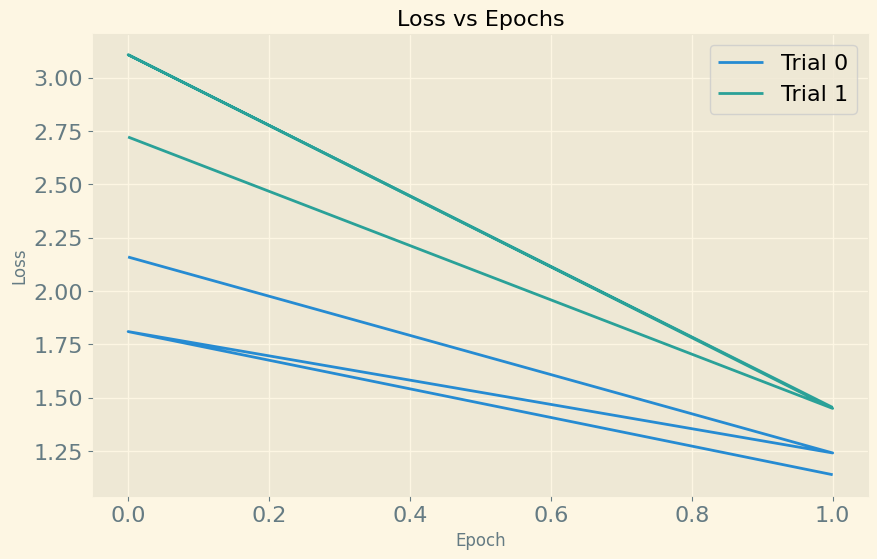

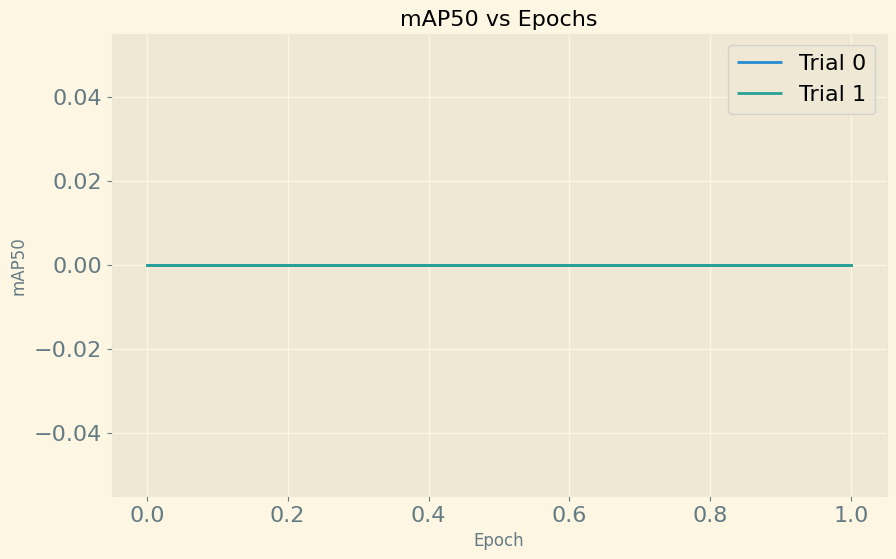

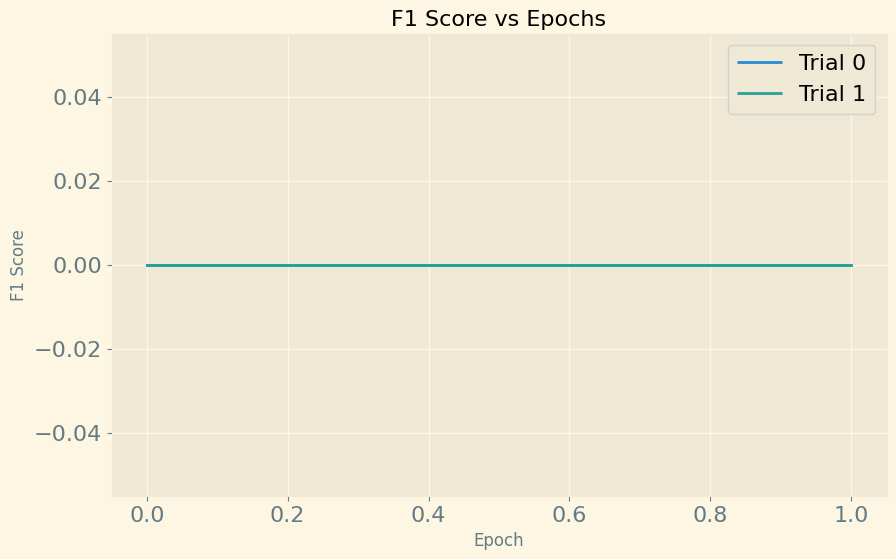

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming HISTORY is a list of dictionaries containing the training logs

# Convert HISTORY into a pandas DataFrame
history_df = pd.DataFrame(HISTORY)

# Plot loss vs epochs for each trial
plt.figure(figsize=(10, 6))
for trial in history_df['trial'].unique():
    trial_data = history_df[history_df['trial'] == trial]
    plt.plot(trial_data['epoch'], trial_data['loss'], label=f'Trial {trial}')

plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot mAP50 vs epochs for each trial
plt.figure(figsize=(10, 6))
for trial in history_df['trial'].unique():
    trial_data = history_df[history_df['trial'] == trial]
    plt.plot(trial_data['epoch'], trial_data['map_50'], label=f'Trial {trial}')

plt.title("mAP50 vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("mAP50")
plt.legend()
plt.show()

# Plot F1 Score vs Epochs
plt.figure(figsize=(10, 6))
for trial in history_df['trial'].unique():
    trial_data = history_df[history_df['trial'] == trial]
    plt.plot(trial_data['epoch'], trial_data['f1'], label=f'Trial {trial}')

plt.title("F1 Score vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

# Optionally, you can plot other metrics (like precision, recall, etc.) in a similar way.


# Testing

In [14]:
model.eval()
torch.cuda.empty_cache()

test_dataset = COCODetection(
    root=parent_dir, split='test', transforms = transforms(SMALL_SIZE, False)
)

NameError: name 'model' is not defined

In [ ]:
image, _ = test_dataset[5]
image_int = torch.tensor(image * 255, dtype=torch.uint8)

with torch.no_grad():
    prediction = model([image.to(DEVICE)])
    pred = prediction[0]

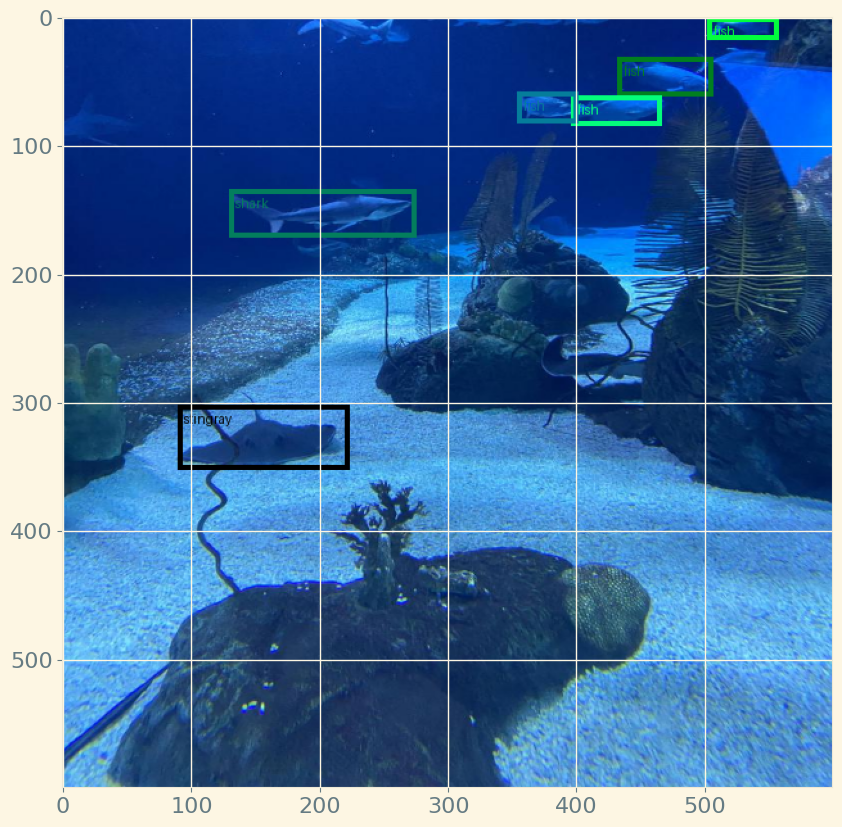

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(
    draw_bounding_boxes(
        image_int,
        pred['boxes'][pred['scores'] > 0.8],
        [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()],
        width = 4
    ).permute(1, 2, 0)
)